## Multiclass Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/a-nadeem9/brca-epigenetic-age-acceleration-immune-multiomics-classifier/blob/main/notebooks/05_multiclass_classification.ipynb)


In [28]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from joblib import parallel_backend
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, label_binarize
from sklearn.feature_selection import f_classif
from sklearn.metrics import (
    balanced_accuracy_score, confusion_matrix,
    roc_auc_score, RocCurveDisplay, roc_curve, auc
)
from sklearn.model_selection   import StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipe
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [29]:
# Monkey‑patch SMOTE if necessary (imbalanced‑learn < 0.13)
def _validate_data(self, X, y=None, reset=True, accept_sparse=None, **kw): return X, y
SMOTE._validate_data = _validate_data

In [30]:
# ────────────────────────────────────────────────
# 0. Constants & random seed
# ────────────────────────────────────────────────
RANDOM_STATE = 2025
CV_SPLITS    = 5
np.random.seed(RANDOM_STATE)

In [31]:
# ────────────────────────────────────────────────
# 1. Load data & pre‑saved split
# ────────────────────────────────────────────────
gene   = pd.read_csv("../X_gene_raw.csv",   index_col=0)
cpg    = pd.read_csv("../X_cpg_raw.csv",    index_col=0)
immune = pd.read_csv("../X_immune_raw.csv", index_col=0)
age    = pd.read_csv("../X_age_raw.csv",    index_col=0)

subtype_map = {"Basal":0,"LumA":1,"LumB":2}
y_cat = pd.read_csv("../multiclass_y_labels_cat.csv", index_col=0).Subtype
y     = y_cat.map(subtype_map).to_numpy()
for df in (cpg, immune, age, y_cat):
    df.index = gene.index

train_idx = np.load("../train_idx.npy")
test_idx  = np.load("../test_idx.npy")
X_ix = np.arange(len(y))[:, None]

print(f"Loaded split: {len(train_idx)} train / {len(test_idx)} test")

Loaded split: 623 train / 70 test


In [32]:
# ────────────────────────────────────────────────
# 2. Top‑K selector
# ────────────────────────────────────────────────
class TopK(BaseEstimator, TransformerMixin):
    def __init__(self, k=50, tag=""): self.k, self.tag = k, tag
    def fit(self, X, y):
        if self.k is None:
            self.keep_ = np.arange(X.shape[1])
        else:
            _, p = f_classif(X, y)
            self.keep_ = np.argsort(p)[: self.k]
        return self
    def transform(self, X): return X[:, self.keep_]

In [33]:
# ────────────────────────────────────────────────
# 3. Block & union helpers
# ────────────────────────────────────────────────
def blk(df, k, tag):
    return Pipeline([
        ("subset", FunctionTransformer(lambda ix, df=df: df.iloc[ix.ravel()].values,
                                       validate=False)),
        ("sel",    TopK(k, tag))
    ])

def make_union(names, k_gene=100, k_cpg=100):
    blocks = {
        "age"   : blk(age,    None,      "age"),
        "immune": blk(immune, None,      "immune"),
        "gene"  : blk(gene,   k_gene,    f"gene{k_gene}"),
        "cpg"   : blk(cpg,    k_cpg,     f"cpg{k_cpg}")
    }
    return FeatureUnion([(n, blocks[n]) for n in names], n_jobs=-1)

X_sets = {
    "age"        : make_union(("age",)),
    "immune"     : make_union(("immune",)),
    "gene"       : make_union(("gene",)),
    "cpg"        : make_union(("cpg",)),
    "age_immune" : make_union(("age","immune")),
    "all"        : make_union(("age","immune","gene","cpg")),
}

In [34]:
# ────────────────────────────────────────────────
# 4. Gate&Fine meta‑estimator (binary gate + 4 fine options)
# ────────────────────────────────────────────────
class GateAndFine(BaseEstimator):
    def __init__(self, gate=None, fine=None, threshold=0.50):
        self.gate, self.fine, self.threshold = gate, fine, threshold

    def get_params(self, deep=True):
        return {"gate":self.gate, "fine":self.fine, "threshold":self.threshold}

    def set_params(self, **p):
        for k,v in p.items(): setattr(self, k, v)
        return self

    def fit(self, X, y):
        y_gate = (y==0).astype(int)
        self.gate_ = clone(self.gate).fit(X, y_gate)
        mask = y!=0
        self.fine_ = clone(self.fine).fit(X[mask], y[mask]-1)
        return self

    def predict_proba(self, X):
        p0   = self.gate_.predict_proba(X)[:,1]
        mask = p0 >= self.threshold
        P    = np.zeros((len(X),3))
        P[mask,0] = 1.0
        if (~mask).any():
            pf = self.fine_.predict_proba(X[~mask])
            P[~mask,1:] = pf
        return P / P.sum(axis=1, keepdims=True)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [35]:
# define gate model
gate_model = LGBMClassifier(
    n_estimators=400, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    objective="binary", random_state=RANDOM_STATE, n_jobs=-1
)

In [36]:
# define four fine models
fine_models = {
    "XGB": XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary:logistic", eval_metric="logloss",
        use_label_encoder=False, random_state=RANDOM_STATE, n_jobs=-1
    ),
    "LGBM": LGBMClassifier(
        n_estimators=400, learning_rate=0.05, num_leaves=31,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary", random_state=RANDOM_STATE, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", C=3, gamma="scale",
        probability=True, random_state=RANDOM_STATE
    ),
    "RF": RandomForestClassifier(
        n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1
    )
}

In [37]:
# ────────────────────────────────────────────────
# 5. Recover feature names reliably
# ────────────────────────────────────────────────
orig = {"age":age, "immune":immune, "gene":gene, "cpg":cpg}
def get_feature_names(union):
    names = []
    for name, trans in union.transformer_list:
        tag = trans.named_steps["sel"].tag
        cols= orig[name].columns
        keep= cols if trans.named_steps["sel"].k is None else cols[trans.named_steps["sel"].keep_]
        names += [f"{tag}:{c}" for c in keep]
    return np.array(names)

In [38]:
# ────────────────────────────────────────────────
# 6. Confusion / ROC plot helper
# ────────────────────────────────────────────────
def plot_confusion(cm, labels, title, ax):
    im = ax.imshow(cm, cmap="Blues", vmin=0)
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,cm[i,j],ha="center",
                    color="white" if cm[i,j]>cm.max()/2 else "black")
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")


=== Feature set: age ===

>>> age + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:12:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.482  HO_BA=0.476  AUC=0.638

>>> age + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Number of positive: 375, number of negative: 375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Wa

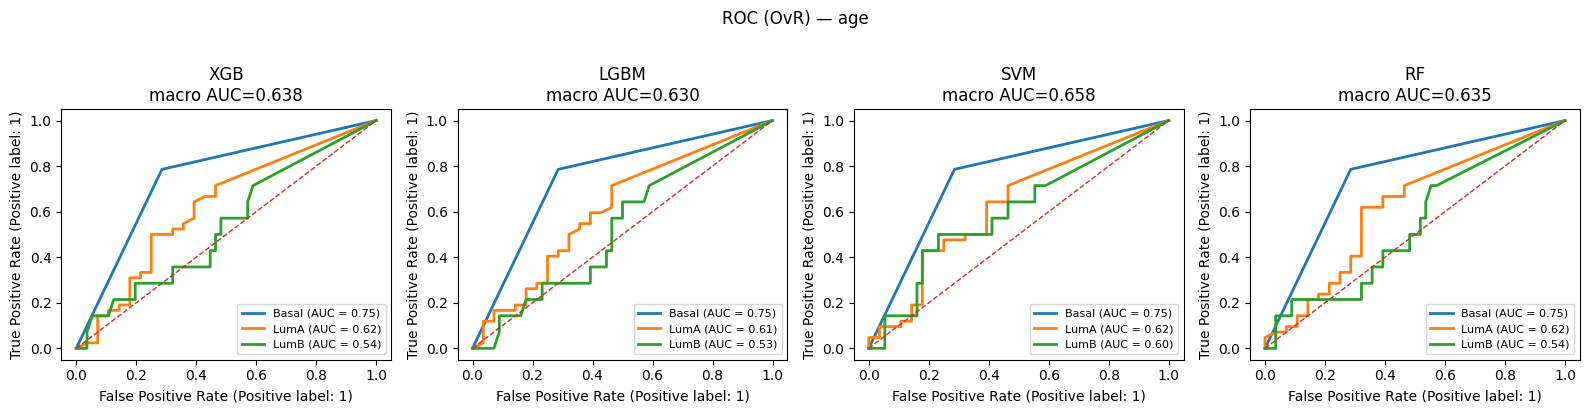

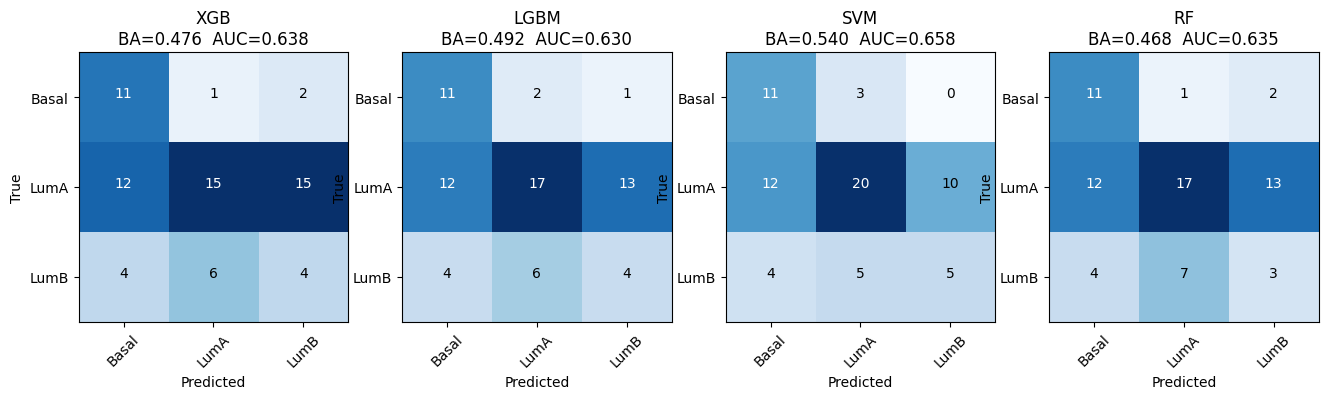

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC  thr
model                                                   
SVM           0.493        0.021    0.540     0.658  0.4
LGBM          0.490        0.046    0.492     0.630  0.4
XGB           0.482        0.031    0.476     0.638  0.4
RF            0.472        0.043    0.468     0.635  0.4


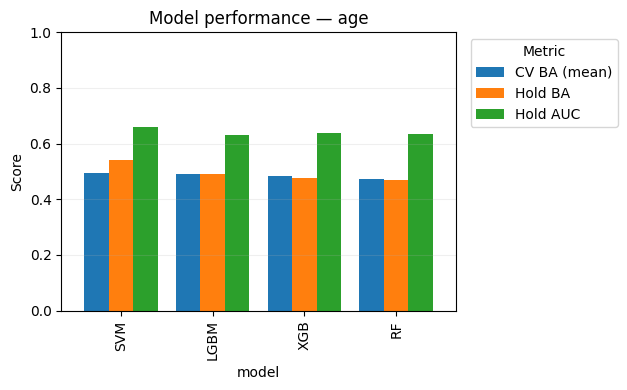


=== Feature set: immune ===

>>> immune + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.588  HO_BA=0.587  AUC=0.710

>>> immune + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

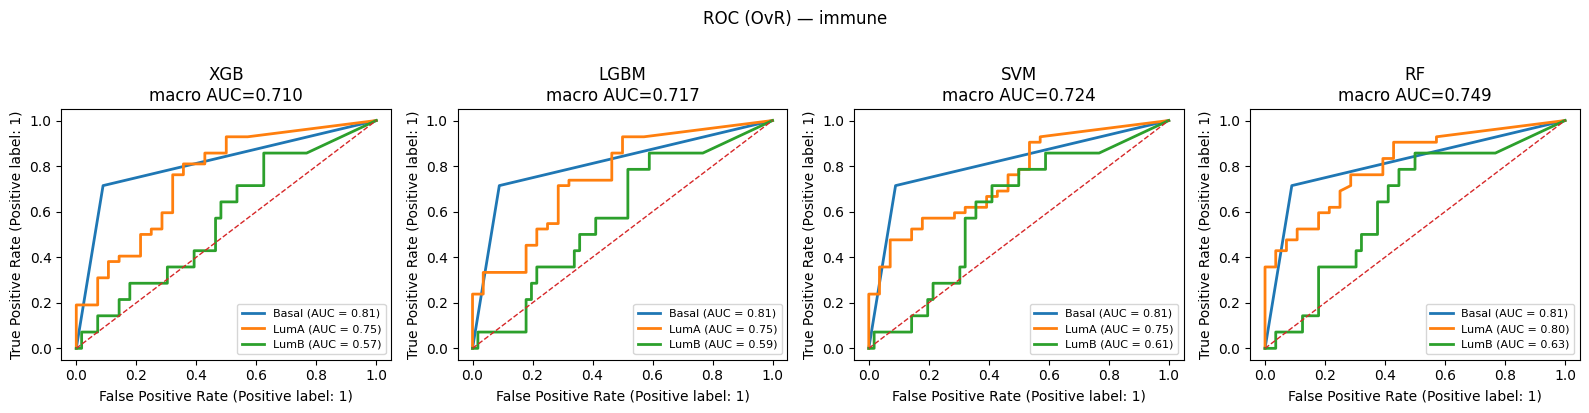

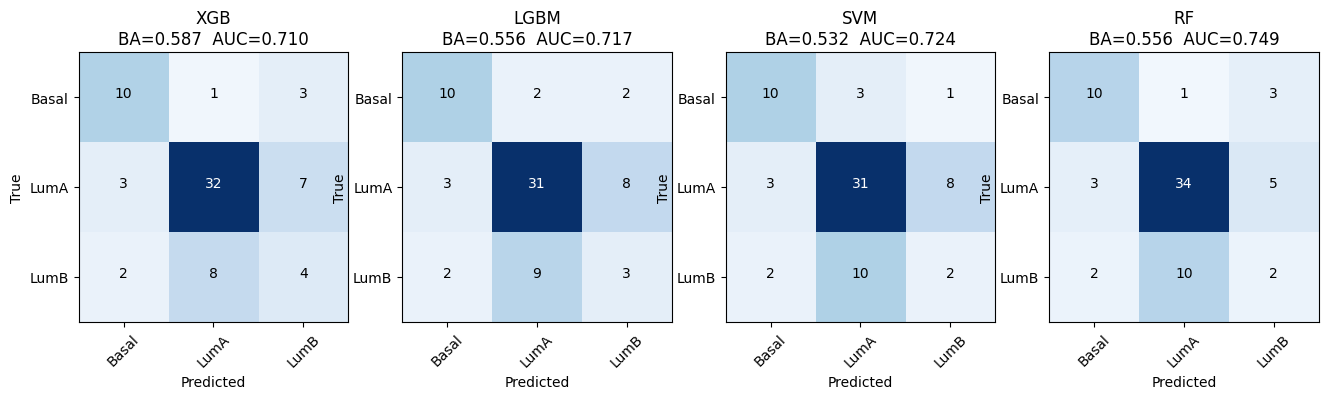

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC  thr
model                                                   
XGB           0.588        0.028    0.587     0.710  0.4
LGBM          0.571        0.019    0.556     0.717  0.4
RF            0.581        0.034    0.556     0.749  0.4
SVM           0.582        0.047    0.532     0.724  0.4


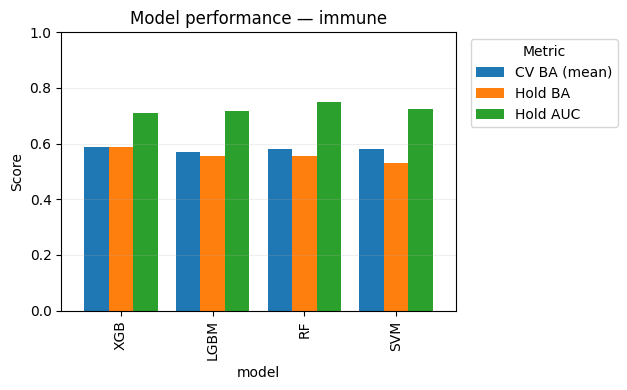


=== Feature set: gene ===

>>> gene + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19380
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:15:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.855  HO_BA=0.897  AUC=0.979

>>> gene + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19380
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

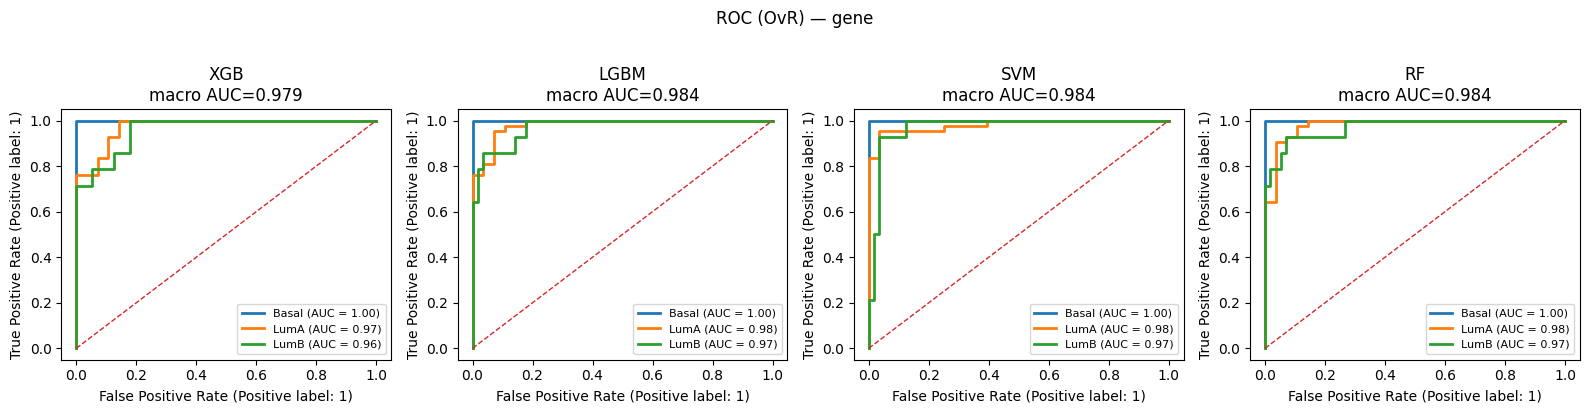

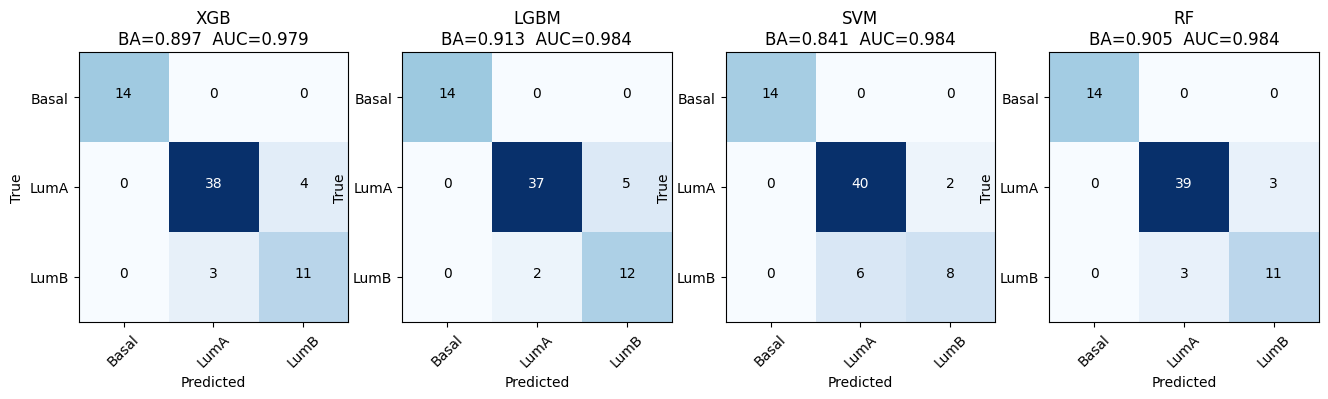

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC  thr
model                                                   
LGBM          0.848        0.040    0.913     0.984  0.4
RF            0.843        0.035    0.905     0.984  0.4
XGB           0.855        0.023    0.897     0.979  0.4
SVM           0.778        0.036    0.841     0.984  0.4


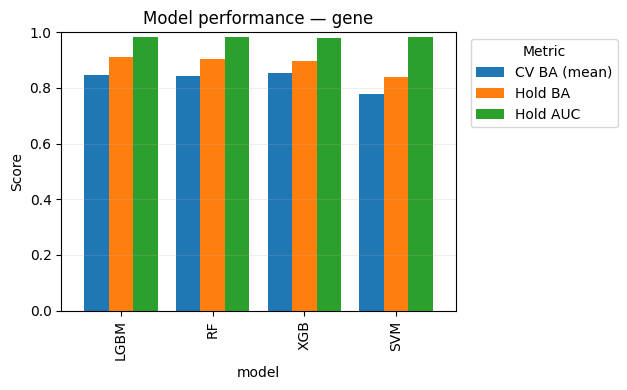


=== Feature set: cpg ===

>>> cpg + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:17:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.50  CV_BA=0.350  HO_BA=0.389  AUC=0.510

>>> cpg + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Number of positive: 375, number of negative: 375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12515
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGB

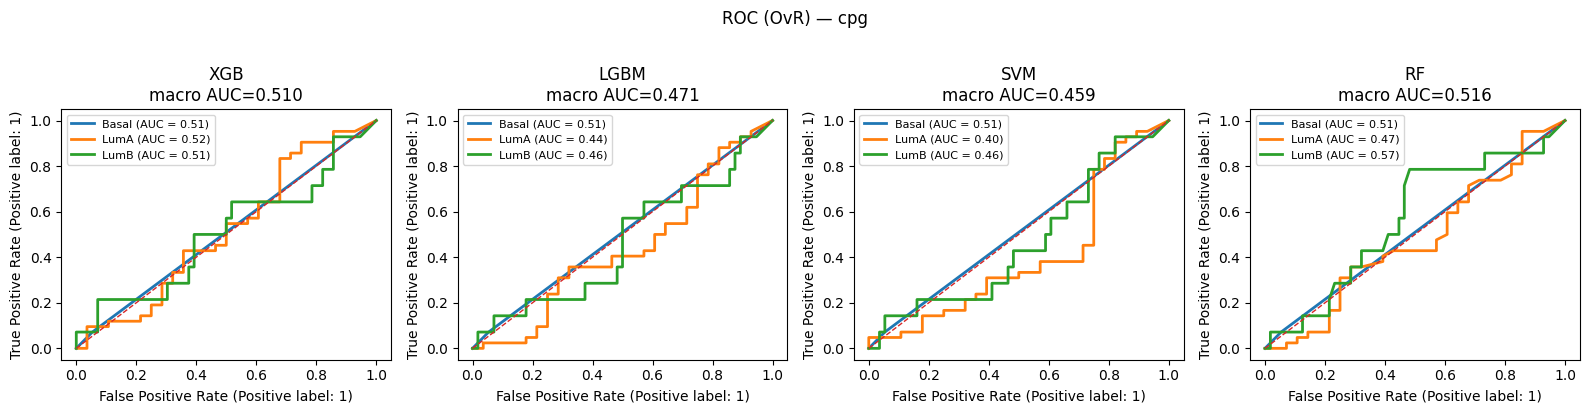

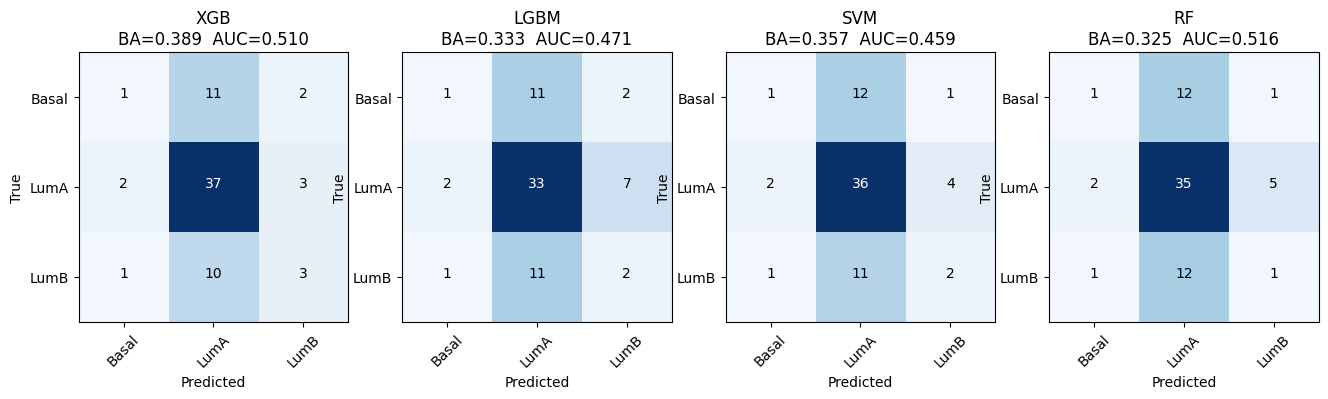

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC   thr
model                                                    
XGB           0.350        0.013    0.389     0.510  0.50
SVM           0.363        0.007    0.357     0.459  0.55
LGBM          0.345        0.031    0.333     0.471  0.50
RF            0.341        0.027    0.325     0.516  0.50


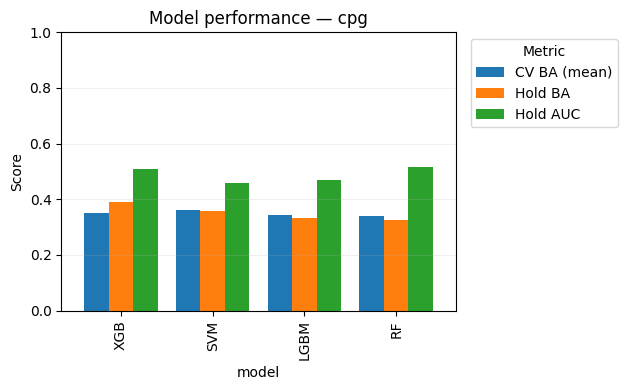


=== Feature set: age_immune ===

>>> age_immune + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4435
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:19:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.655  HO_BA=0.619  AUC=0.777

>>> age_immune + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4435
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

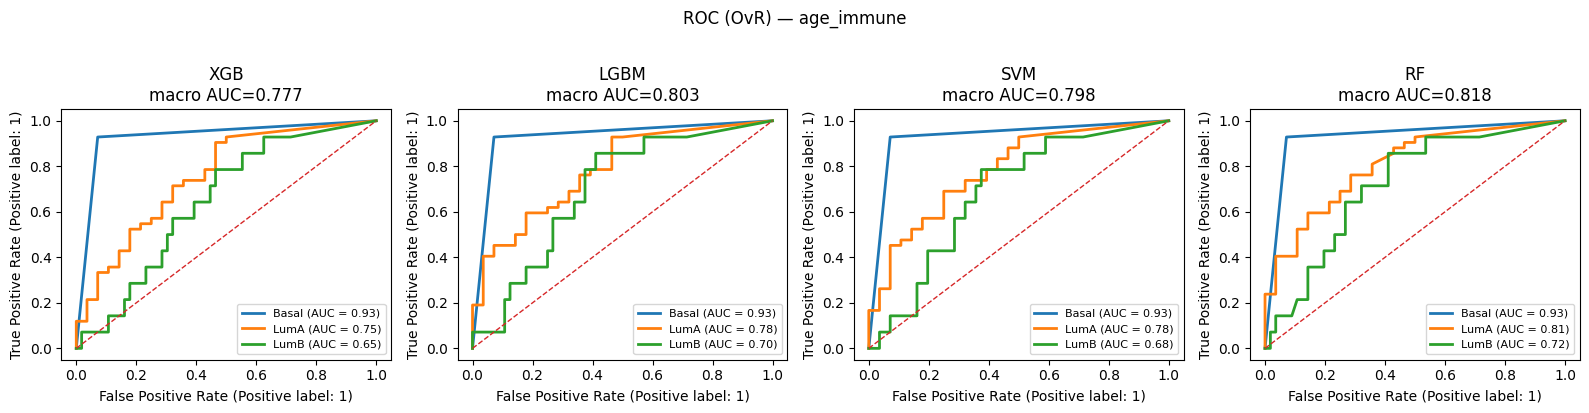

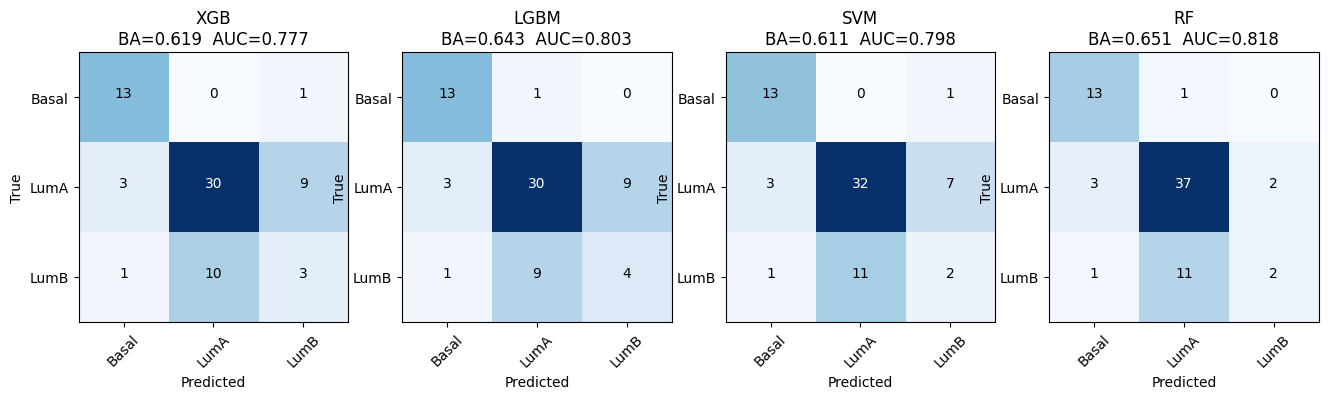

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC  thr
model                                                   
RF            0.653        0.040    0.651     0.818  0.4
LGBM          0.647        0.049    0.643     0.803  0.4
XGB           0.655        0.034    0.619     0.777  0.4
SVM           0.654        0.053    0.611     0.798  0.4


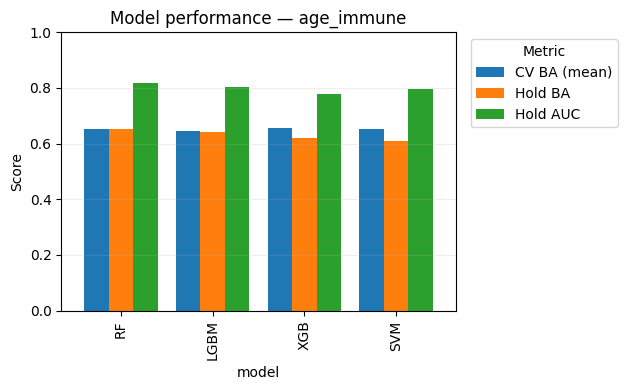


=== Feature set: all ===

>>> all + fine=XGB
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36589
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:21:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 thr=0.40  CV_BA=0.828  HO_BA=0.873  AUC=0.971

>>> all + fine=LGBM
[LightGBM] [Info] Number of positive: 375, number of negative: 750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36589
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

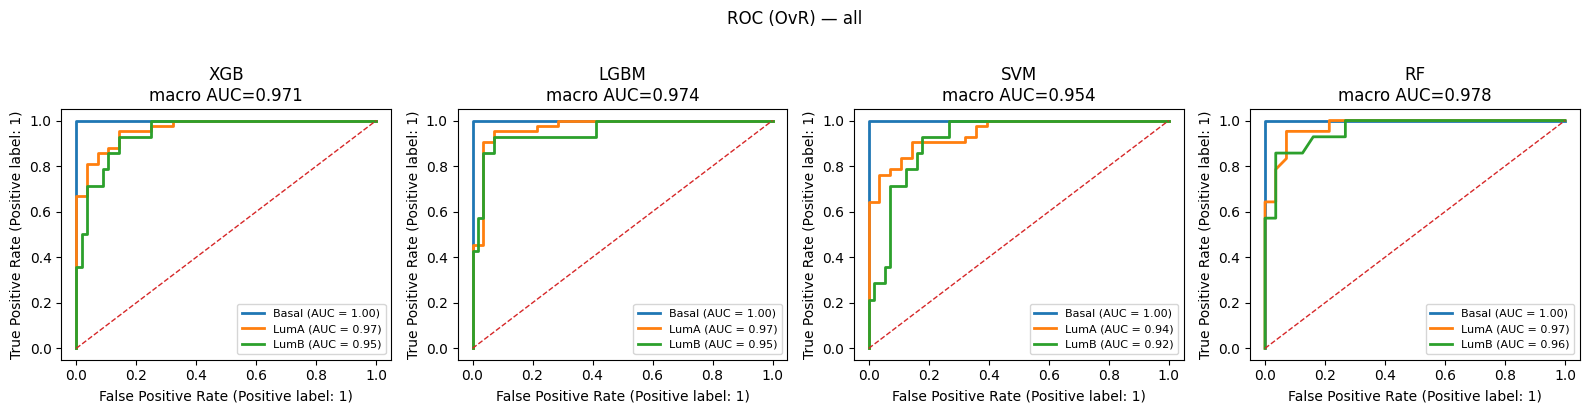

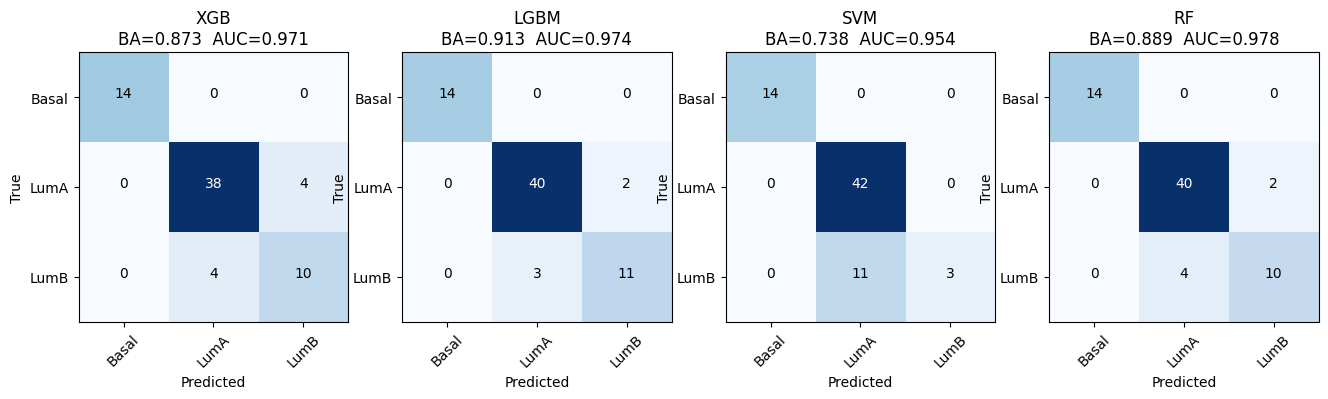

       CV BA (mean)  CV BA (std)  Hold BA  Hold AUC  thr
model                                                   
LGBM          0.841        0.020    0.913     0.974  0.4
RF            0.829        0.026    0.889     0.978  0.4
XGB           0.828        0.016    0.873     0.971  0.4
SVM           0.762        0.034    0.738     0.954  0.4


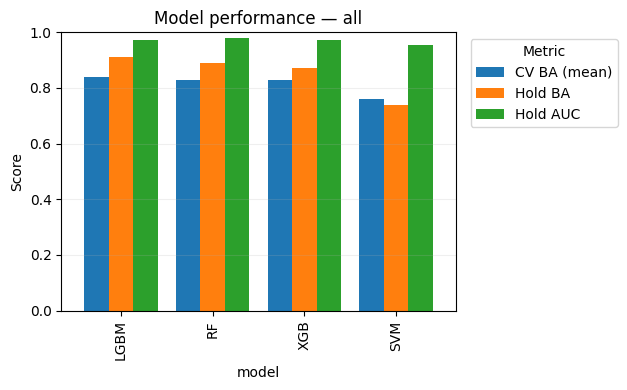

In [39]:
# ────────────────────────────────────────────────
#  7. Loop: each feature‐set × each fine model
# ────────────────────────────────────────────────
cv  = StratifiedKFold(CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
lbl = ["Basal","LumA","LumB"]
results = {}

rows = []  # local holder reused per feature set

for fs_name, union in X_sets.items():
    print(f"\n=== Feature set: {fs_name} ===")

    # grid of ROC axes, one per model
    fig_roc, axs_roc = plt.subplots(1, len(fine_models),
                                    figsize=(4*len(fine_models), 4),
                                    squeeze=False)

    # confusion matrices grid stays the same
    fig_cm, axs_cm = plt.subplots(1, len(fine_models),
                                  figsize=(4*len(fine_models), 4),
                                  squeeze=False)

    rows = []  # reset for this feature set

    for j, (fm_name, fine_model) in enumerate(fine_models.items()):
        tag = f"{fs_name} + fine={fm_name}"
        print(f"\n>>> {tag}")

        pipe = ImbPipe([
            ("feat", union),
            ("sc"  , StandardScaler()),
            ("sm"  , SMOTE(random_state=RANDOM_STATE)),
            ("clf" , GateAndFine(gate=gate_model,
                                 fine=fine_model,
                                 threshold=0.50))
        ])

        search = GridSearchCV(
            pipe,
            {"clf__threshold": np.linspace(0.40, 0.60, 5)},
            cv=cv, scoring="balanced_accuracy",
            n_jobs=-1, refit=True, verbose=0
        )

        with parallel_backend("threading"):
            search.fit(X_ix[train_idx], y[train_idx])

        best   = search.best_estimator_
        best_i = search.best_index_
        key    = (fs_name, fm_name)
        results[key] = best

        # hold‑out evaluation
        preds = best.predict(X_ix[test_idx])
        prob  = best.predict_proba(X_ix[test_idx])
        ba    = balanced_accuracy_score(y[test_idx], preds)
        aucv  = roc_auc_score(y[test_idx], prob, multi_class="ovr")
        print(f" thr={best.named_steps['clf'].threshold:.2f}  CV_BA={search.best_score_:.3f}  HO_BA={ba:.3f}  AUC={aucv:.3f}")

        # per-class ROC curves on this model's subplot
        ax_roc_m = axs_roc[0, j]
        for k, lab in enumerate(lbl):
            RocCurveDisplay.from_predictions(
                (y[test_idx] == k).astype(int),
                prob[:, k],
                name=lab,
                ax=ax_roc_m,
                linewidth=2
            )
        ax_roc_m.plot([0, 1], [0, 1], "--", lw=1)
        ax_roc_m.set_title(f"{fm_name}\nmacro AUC={aucv:.3f}")
        ax_roc_m.legend(fontsize=8)

        # Confusion matrix
        cm = confusion_matrix(y[test_idx], preds)
        ax_cm = axs_cm[0, j]
        plot_confusion(cm, lbl, f"{fm_name}\nBA={ba:.3f}  AUC={aucv:.3f}", ax_cm)

        # store for summary table
        rows.append({
            "model": fm_name,
            "CV BA (mean)": search.cv_results_["mean_test_score"][best_i],
            "CV BA (std)":  search.cv_results_["std_test_score"][best_i],
            "Hold BA":      ba,
            "Hold AUC":     aucv,
            "thr":          best.named_steps["clf"].threshold
        })

    # finalize per-model ROC grid 
    fig_roc.suptitle(f"ROC (OvR) — {fs_name}", y=1.02)
    fig_roc.tight_layout()
    plt.show()

    fig_cm.suptitle(f"Confusion matrices — {fs_name}", y=1.02)
    fig_cm.tight_layout()
    plt.show()

    # text summary
    df = (pd.DataFrame(rows)
            .set_index("model")
            .round(3)
            .sort_values("Hold BA", ascending=False))
    print(df)

    # grouped bar chart
    metrics = ["CV BA (mean)", "Hold BA", "Hold AUC"]
    metrics = [m for m in metrics if m in df.columns]

    if metrics:
        df_plot = df[metrics]
        fig_bar_w = max(6, 1.6 * len(df_plot))
        ax = df_plot.plot(kind="bar", figsize=(fig_bar_w, 4), width=0.8)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Score")
        ax.set_title(f"Model performance — {fs_name}")
        ax.grid(axis="y", alpha=0.2)
        ax.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()


### Per‑class ROC overlays

In [68]:
def plot_roc_per_class_overlay(fs_name, X_sets, fine_models, results, X_ix, y, train_idx, test_idx, lbl):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc, roc_auc_score, balanced_accuracy_score, confusion_matrix

    union = X_sets[fs_name]

    fig, axs = plt.subplots(1, len(lbl), figsize=(5*len(lbl), 4), sharex=True, sharey=True)
    axs = np.atleast_1d(axs)

    for fm_name, _ in fine_models.items():
        best = results[(fs_name, fm_name)]
        prob = best.predict_proba(X_ix[test_idx])

        for k, lab in enumerate(lbl):
            y_true = (y[test_idx] == k).astype(int)
            fpr, tpr, _ = roc_curve(y_true, prob[:, k])
            auc_k = auc(fpr, tpr)
            axs[k].plot(fpr, tpr, lw=2, label=f"{fm_name} (AUC={auc_k:.3f})")

    for k, lab in enumerate(lbl):
        axs[k].plot([0, 1], [0, 1], "--", lw=1, color="gray")
        axs[k].set_title(lab)
        axs[k].set_xlabel("FPR")
        if k == 0:
            axs[k].set_ylabel("TPR")
        axs[k].legend(fontsize=8)

    fig.suptitle(f"ROC (OvR) — per class — {fs_name}", y=1.02)
    plt.tight_layout()
    plt.show()

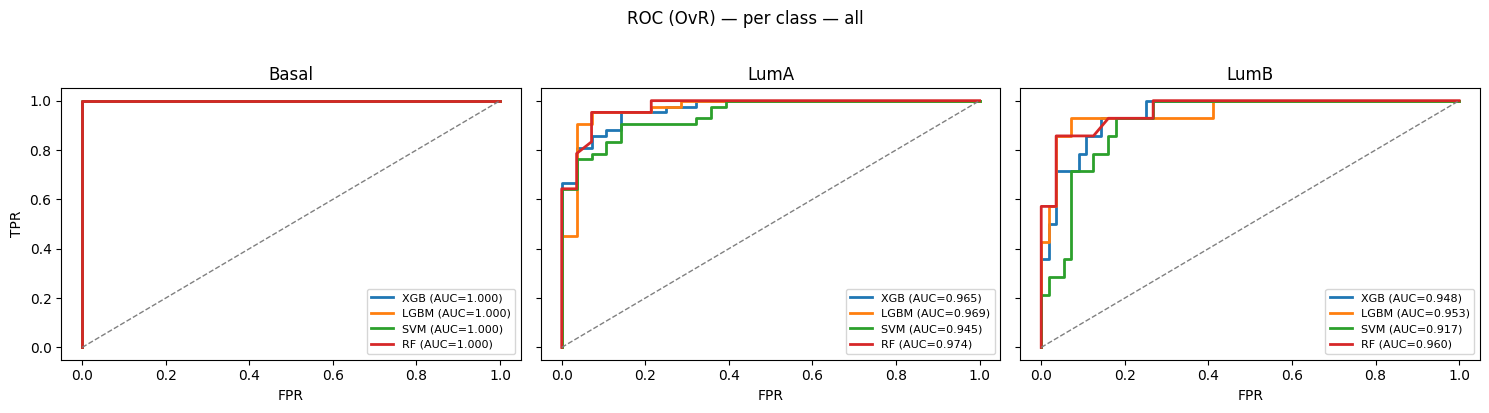

In [69]:
plot_roc_per_class_overlay("all", X_sets, fine_models, results, X_ix, y, train_idx, test_idx, lbl)


Basal is easy: every model gets AUC = 1.00, so the gate is basically perfect there. 

The real challenge is telling LumA from LumB. For both LumA and LumB, the Random Forest is slightly better than LGBM and XGB, and all three beat SVM.

### Per‑class Precision–Recall overlays

In [70]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_per_class_overlay(fs_name, X_sets, fine_models, results, X_ix, y, train_idx, test_idx, lbl):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, len(lbl), figsize=(5*len(lbl), 4), sharex=True, sharey=True)
    axs = np.atleast_1d(axs)

    for fm_name, _ in fine_models.items():
        best = results[(fs_name, fm_name)]
        prob = best.predict_proba(X_ix[test_idx])

        for k, lab in enumerate(lbl):
            y_true = (y[test_idx] == k).astype(int)
            prec, rec, _ = precision_recall_curve(y_true, prob[:, k])
            ap = average_precision_score(y_true, prob[:, k])
            axs[k].plot(rec, prec, lw=2, label=f"{fm_name} (AP={ap:.3f})")

    for k, lab in enumerate(lbl):
        axs[k].set_title(lab)
        axs[k].set_xlabel("Recall")
        if k == 0:
            axs[k].set_ylabel("Precision")
        axs[k].legend(fontsize=8)

    fig.suptitle(f"PR (OvR) — per class — {fs_name}", y=1.02)
    plt.tight_layout()
    plt.show()


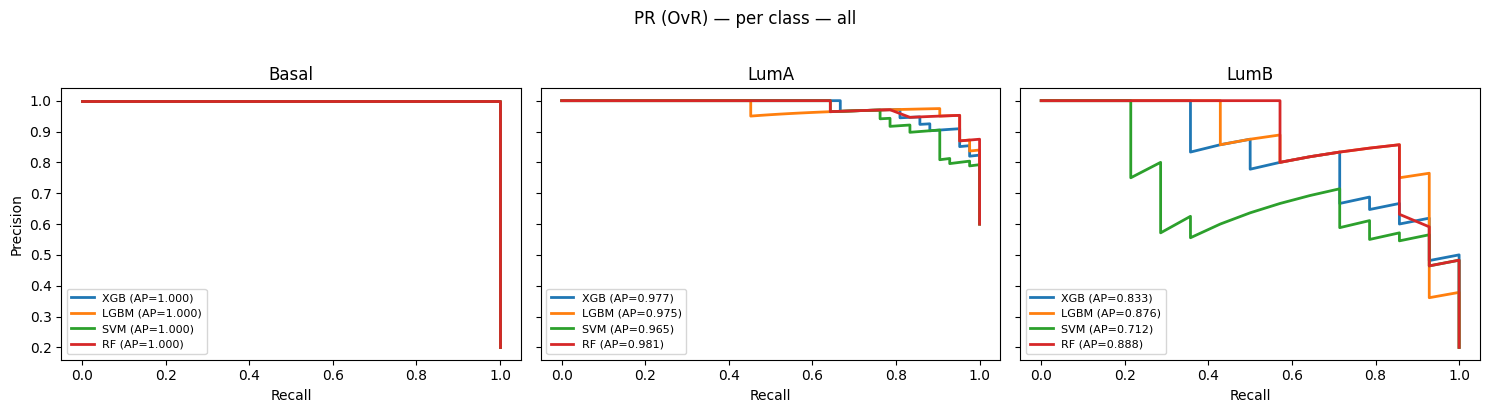

In [71]:
plot_pr_per_class_overlay("all", X_sets, fine_models, results, X_ix, y, train_idx, test_idx, lbl)

Basal is again trivial: every model gets AP = 1.00. For LumA, all models are very strong (AP ≈ 0.97–0.98), with RF slightly best (0.981). 

The real pain point is LumB: precision–recall drops a lot, and the ranking is RF (0.888) > LGBM (0.876) > XGB (0.833) >> SVM (0.712).

### Calibration (reliability) curves 

In [72]:
from sklearn.calibration import calibration_curve

def plot_calibration_per_class(fs_name, X_sets, fine_models, results, X_ix, y, train_idx, test_idx, lbl, n_bins=10):
    import matplotlib.pyplot as plt
    best_name = max(  # pick the best model on Hold BA (or pick explicitly)
        [(name, balanced_accuracy_score(y[test_idx], results[(fs_name,name)].predict(X_ix[test_idx])))
         for name in fine_models.keys()],
        key=lambda x: x[1]
    )[0]
    best = results[(fs_name, best_name)]
    prob = best.predict_proba(X_ix[test_idx])

    fig, axs = plt.subplots(1, len(lbl), figsize=(5*len(lbl), 4), sharex=True, sharey=True)
    axs = np.atleast_1d(axs)

    for k, lab in enumerate(lbl):
        y_true = (y[test_idx] == k).astype(int)
        frac_pos, mean_pred = calibration_curve(y_true, prob[:, k], n_bins=n_bins, strategy="quantile")
        axs[k].plot(mean_pred, frac_pos, marker="o", lw=1.5)
        axs[k].plot([0,1],[0,1],"--", color="gray")
        axs[k].set_title(f"{lab}")
        axs[k].set_xlabel("Predicted prob.")
        if k == 0:
            axs[k].set_ylabel("Observed freq.")

    fig.suptitle(f"Calibration curves — {fs_name} (model={best_name})", y=1.02)
    plt.tight_layout()
    plt.show()


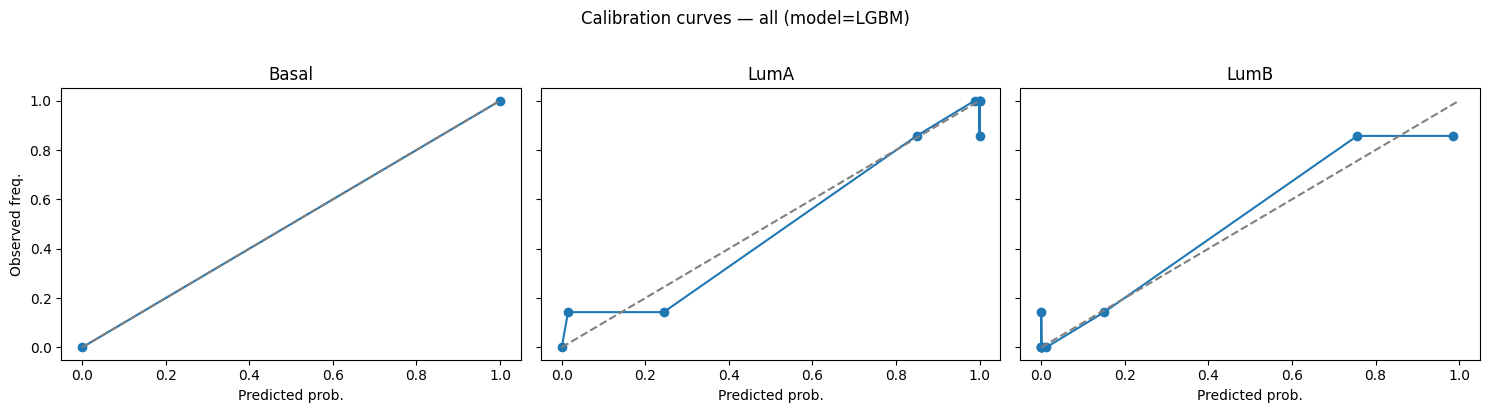

In [73]:
plot_calibration_per_class("all", X_sets, fine_models, results, X_ix, y, train_idx, test_idx, lbl)

Basal is perfectly calibrated—the curve sits on the diagonal. 

For LumA, the model is miscalibrated at the low end (it predicts very small probabilities but you still see some positives) and then becomes roughly OK at higher probabilities; overall it’s a bit wobbly. 

For LumB, calibration is pretty good in the middle, but the model gets over‑confident at the top (it predicts ~0.9–1.0 while the observed frequency is lower).

### SHAP analysis for one chosen model (robust to shap_values format)

In [40]:

import numpy as np
import shap
import matplotlib.pyplot as plt

# Map from block name -> original DataFrame (for feature names)
orig = {
    "age":    age,
    "immune": immune,
    "gene":   gene,
    "cpg":    cpg
}

def get_feature_names(union):
    names = []
    for block_name, trans in union.transformer_list:
        top = trans.named_steps["sel"]
        cols = orig[block_name].columns
        keep = cols if top.k is None else cols[top.keep_]
        names += [f"{top.tag}:{c}" for c in keep]
    return np.array(names)


In [41]:
# Pick model key
model_key = ("all", "XGB")
best_pipe = results[model_key]

In [42]:
# Extract pipeline pieces
feat_union = best_pipe.named_steps["feat"]
scaler     = best_pipe.named_steps["sc"]
gate_m     = best_pipe.named_steps["clf"].gate_
fine_m     = best_pipe.named_steps["clf"].fine_

In [43]:
# Recover feature names
feature_names = get_feature_names(feat_union)

In [44]:
# Build processed train matrices
X_raw       = feat_union.transform(X_ix[train_idx])
X_train     = scaler.transform(X_raw)
lum_mask    = (y[train_idx] != 0)
X_train_fine= X_train[lum_mask]

In [45]:
# Compute SHAP for Gate
explainer_gate = shap.TreeExplainer(gate_m, feature_perturbation="interventional")
sv_g = explainer_gate.shap_values(X_train)
# if returned as list [neg, pos], pick the positive‐class, else take array
sv_gate = sv_g[1] if isinstance(sv_g, list) else sv_g

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [46]:
# Compute SHAP for Fine
explainer_fine = shap.TreeExplainer(fine_m, feature_perturbation="interventional")
sv_f = explainer_fine.shap_values(X_train_fine)
sv_fine = sv_f[1] if isinstance(sv_f, list) else sv_f

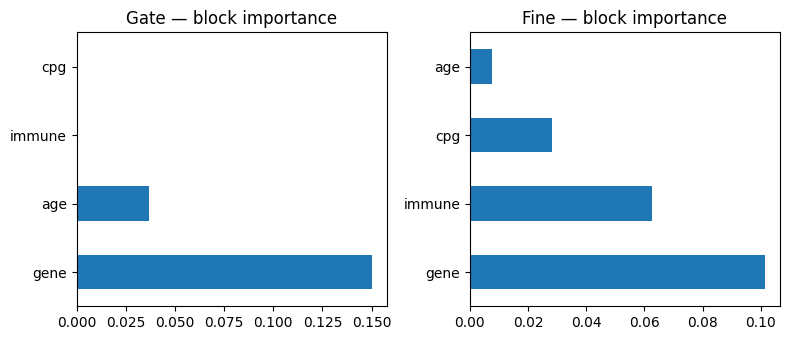

In [75]:
def shap_block_importance(sv, feature_names, union):
    # map each feature to its block
    blocks = []
    for block_name, trans in union.transformer_list:
        top  = trans.named_steps["sel"]
        cols = orig[block_name].columns
        keep = cols if top.k is None else cols[top.keep_]
        blocks += [block_name] * len(keep)

    blocks = np.array(blocks)
    mean_abs = np.abs(sv).mean(axis=0)
    imp = pd.Series(0.0, index=[bn for bn, _ in union.transformer_list])
    for bn in imp.index:
        imp[bn] = mean_abs[blocks == bn].mean()
    return imp.sort_values(ascending=False)

imp_gate = shap_block_importance(sv_gate, feature_names, feat_union)
imp_fine = shap_block_importance(sv_fine, feature_names, feat_union)

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))
imp_gate.plot(kind="barh", ax=axs[0]); axs[0].set_title("Gate — block importance")
imp_fine.plot(kind="barh", ax=axs[1]); axs[1].set_title("Fine — block importance")
plt.tight_layout(); plt.show()


Genes do almost all the work. In the gate (Basal vs Luminal), SHAP says the signal is heavily gene‑driven, with a small bump from age and basically nothing from immune/cpg. 

In the fine model (LumA vs LumB), genes are still #1, but immune features matter second most, cpg contributes a bit, and age is negligible.

In [47]:
# Rank & print top‑20
def rank_shap(sv, names, top_k=20):
    mean_abs = np.abs(sv).mean(axis=0)
    idx      = np.argsort(mean_abs)[::-1][:top_k]
    return list(zip(names[idx], mean_abs[idx]))

print("🔹 Top 20 Gate features (Basal vs Luminal):")
for feat, val in rank_shap(sv_gate, feature_names):
    print(f"{feat:30s} {val:.4f}")

print("\n🔹 Top 20 Fine features (LumA vs LumB):")
for feat, val in rank_shap(sv_fine, feature_names):
    print(f"{feat:30s} {val:.4f}")

🔹 Top 20 Gate features (Basal vs Luminal):
gene100:ENSG00000129514.8      2.3397
gene100:ENSG00000115648.14     1.3915
gene100:ENSG00000173467.9      1.2821
gene100:ENSG00000091831.24     1.1718
gene100:ENSG00000100219.16     0.9634
gene100:ENSG00000120262.10     0.8609
gene100:ENSG00000259459.6      0.5269
gene100:ENSG00000148468.17     0.3470
gene100:ENSG00000178935.5      0.1974
gene100:ENSG00000054598.9      0.1925
gene100:ENSG00000187720.14     0.1776
gene100:ENSG00000171428.15     0.1698
gene100:ENSG00000106541.12     0.1614
gene100:ENSG00000168350.8      0.1462
gene100:ENSG00000154548.9      0.1392
gene100:ENSG00000206113.11     0.1245
gene100:ENSG00000172425.12     0.1164
gene100:ENSG00000259725.1      0.0941
gene100:ENSG00000160180.15     0.0936
gene100:ENSG00000253125.1      0.0759

🔹 Top 20 Fine features (LumA vs LumB):
gene100:ENSG00000054598.9      0.8544
gene100:ENSG00000186832.9      0.7347
gene100:ENSG00000005513.10     0.5920
gene100:ENSG00000198729.5      0.5001
gene1

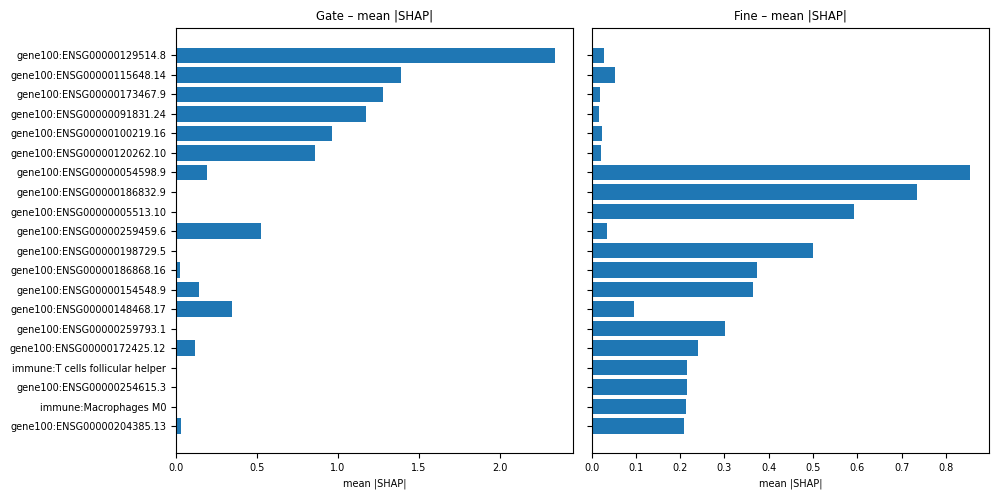

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mean_abs_shap(sv):
    # works for both shap.Explanation and raw numpy arrays
    return np.abs(getattr(sv, "values", sv)).mean(axis=0)

def side_by_side_shap_bars(sv_gate, sv_fine, feature_names,
                           top_n=20, figsize=(11, 6), font_size=8):
    gate = mean_abs_shap(sv_gate)
    fine = mean_abs_shap(sv_fine)

    df = pd.DataFrame({"Gate": gate, "Fine": fine}, index=feature_names)

    # order features by their max importance across the two models
    order = df.max(axis=1).sort_values().index[-top_n:]
    df = df.loc[order]

    plt.rcParams.update({"font.size": font_size})

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=figsize)

    axes[0].barh(df.index, df["Gate"])
    axes[0].set_title("Gate – mean |SHAP|")
    axes[0].set_xlabel("mean |SHAP|")

    axes[1].barh(df.index, df["Fine"])
    axes[1].set_title("Fine – mean |SHAP|")
    axes[1].set_xlabel("mean |SHAP|")

    # smaller tick labels if you want them even tinier
    axes[0].tick_params(labelsize=font_size)
    axes[1].tick_params(labelsize=font_size)

    plt.tight_layout()
    plt.show()

# usage
side_by_side_shap_bars(sv_gate, sv_fine, feature_names, top_n=20, figsize=(10, 5), font_size=7)


The gate (Basal vs. Luminal) is driven almost entirely by a few genes, with ENSG00000129514.8 clearly dominating; immune signals are basically negligible there. 

The fine model (LumA vs. LumB) relies on a different gene set—notably ENSG00000054598.9, ENSG00000135612.11, ENSG00000105513.10, etc.—and immune features (e.g., T cells follicular helper, Macrophages M0) now matter non‑trivially, matching the block‑level view you showed earlier. 

In short: genes separate Basal from Luminal; genes + immune separate LumA from LumB.

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mean_abs_shap(sv):
    # works for both shap.Explanation and raw numpy arrays
    return np.abs(getattr(sv, "values", sv)).mean(axis=0)

def side_by_side_shap_bars(sv_gate, sv_fine, feature_names,
                           top_n=20, figsize=(11, 6), font_size=8):
    gate = mean_abs_shap(sv_gate)
    fine = mean_abs_shap(sv_fine)

    df = pd.DataFrame({"Gate": gate, "Fine": fine}, index=feature_names)

    # order features by their max importance across the two models
    order = df.max(axis=1).sort_values().index[-top_n:]
    df = df.loc[order]

    # Reverse for barh so the top feature is at the top visually
    df = df[::-1]

    plt.rcParams.update({"font.size": font_size})

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=figsize)

    # Plot Gate
    axes[0].barh(df.index, df["Gate"])
    axes[0].set_title("Gate – mean |SHAP|")
    axes[0].set_xlabel("mean |SHAP|")

    # Plot Fine
    axes[1].barh(df.index, df["Fine"])
    axes[1].set_title("Fine – mean |SHAP|")
    axes[1].set_xlabel("mean |SHAP|")

    axes[0].tick_params(labelsize=font_size)
    axes[1].tick_params(labelsize=font_size)

    plt.tight_layout()
    plt.show()


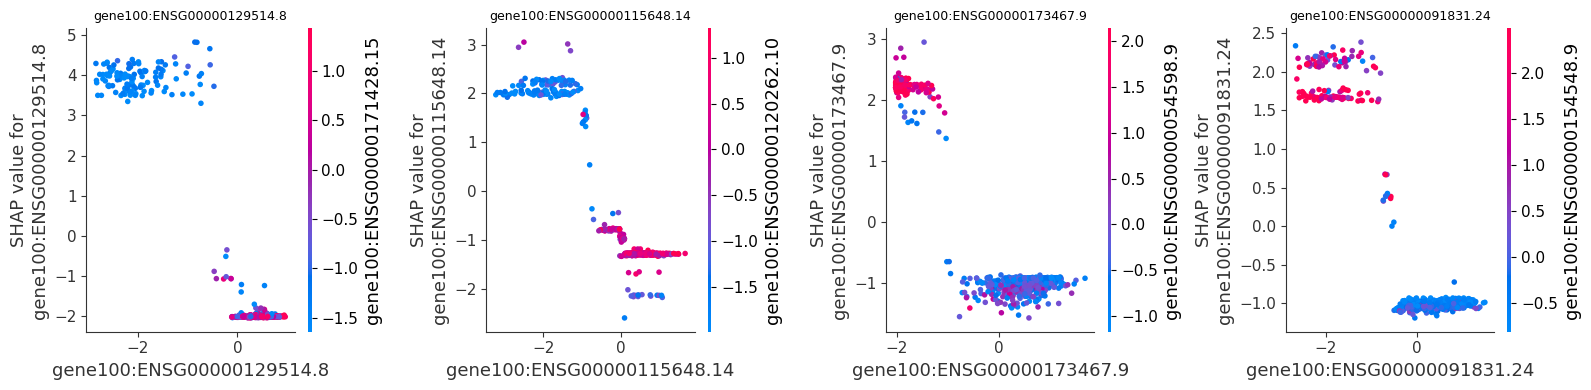

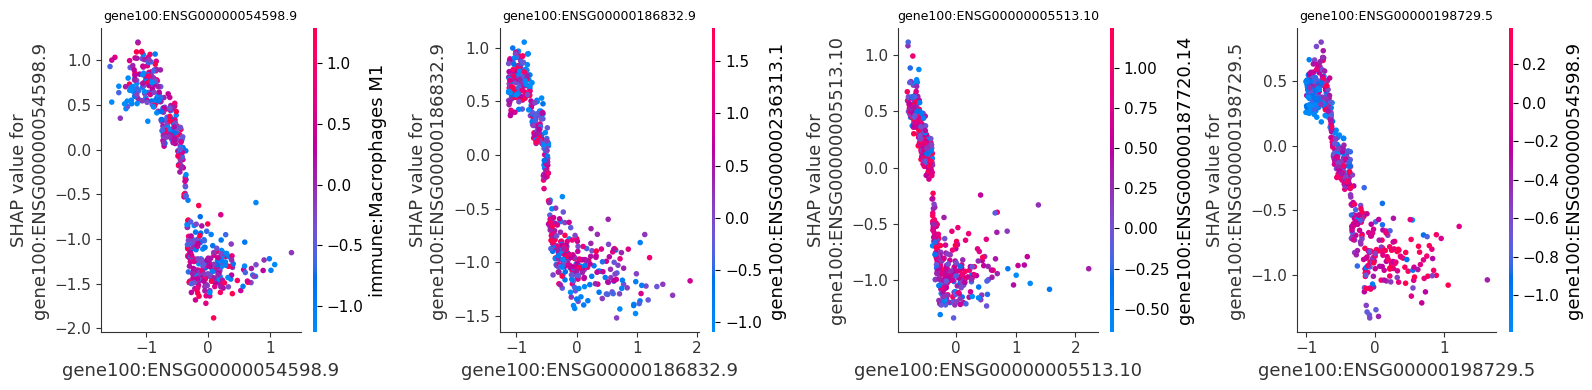

In [ ]:
def dependence_row(sv, X, feature_names, top_feats, ncols=4):
    import shap, numpy as np, matplotlib.pyplot as plt
    n = len(top_feats)
    ncols = min(ncols, n)
    fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 4), squeeze=False)
    axes = axes.ravel()

    for i, feat in enumerate(top_feats[:ncols]):
        ax = axes[i]
        fidx = np.where(feature_names == feat)[0][0]
        ints = shap.utils.approximate_interactions(fidx, sv, X)
        color_idx = ints[0] if len(ints) else None

        shap.dependence_plot(
            fidx, sv, X, feature_names=feature_names,
            interaction_index=color_idx, ax=ax, show=False
        )
        ax.set_title(feat, fontsize=9)

    for k in range(i+1, ncols):
        axes[k].axis("off")
    plt.tight_layout(); plt.show()


top_feats_gate = [f for f, _ in top20_gate]
top_feats_fine = [f for f, _ in top20_fine]
dependence_row(sv_gate, X_train,      feature_names, top_feats_gate, ncols=4)
dependence_row(sv_fine, X_train_fine, feature_names, top_feats_fine, ncols=4)


- Gate (Basal vs Luminal) dependence plots - Fig. 1
Those top gate genes behave almost like hard thresholds: you see two tight clouds, one with very high SHAP (pushing to Basal) and one with very negative SHAP (pushing to Luminal), with a sharp transition around ~0 on the x‑axis. The colour (other interacting genes) barely changes the picture, so the gate’s decision is mostly 1D per gene and highly separable.

 In short: a few genes almost deterministically route samples to Basal vs. Luminal.

- Fine (LumA vs LumB) dependence plots - Fig. 2
Here the shapes are smooth and clearly non‑linear (" monotonic decreasing"): as the gene value increases, the SHAP value drops, i.e. it pushes the prediction toward the opposite Luminal subtype. 
The colour gradients (e.g., Macrophages M1, other genes) show some vertical spread -> there are interaction effects, but they’re secondary. The main effect is still along the x‑feature.

Bottom line: LumA/LumB separation is driven by a handful of genes with strong, mostly monotonic effects, modulated a bit by immune signals.